### Technical indicators 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [1]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

### database paths

In [5]:
cash_nse_data = 'C:\\Users\\sahil\\3D Objects\\data_base\\nse_cash_data'
cash_fut_data = 'C:\\Users\\sahil\\3D Objects\\data_base\\nse_fut_data'
clean_options_data = 'C:\\Users\\sahil\\3D Objects\\data_base\\clean_options_data'

script_names = ['$BANKNIFTY-NSE.csv', '$NIFTY-NSE.csv', '$INDIAVIX-NSE.csv']

### Loading nifty data minute data 

In [6]:
df = pd.read_csv(cash_nse_data + "\\" + script_names[1])
df.index = pd.to_datetime(df.Date + " " + df.Time)
df.sort_index(inplace=True)
df.head()

,Ticker,Date,Time,Open,High,Low,Close,Volume,OI
2010-01-21 10:00:00,$NIFTY-NSE,2010-01-21,10:00:00,5194.8501,5195.7002,5194.1001,5195.7002,27,0
2010-01-21 10:01:00,$NIFTY-NSE,2010-01-21,10:01:00,5195.7998,5197.5000,5195.7998,5197.3999,25,0
2010-01-21 10:02:00,$NIFTY-NSE,2010-01-21,10:02:00,5197.5498,5198.2500,5197.2002,5198.0000,25,0
2010-01-21 10:03:00,$NIFTY-NSE,2010-01-21,10:03:00,5198.2002,5199.1001,5197.9502,5198.8501,27,0
2010-01-21 10:04:00,$NIFTY-NSE,2010-01-21,10:04:00,5198.9502,5200.7998,5198.8999,5200.6499,29,0


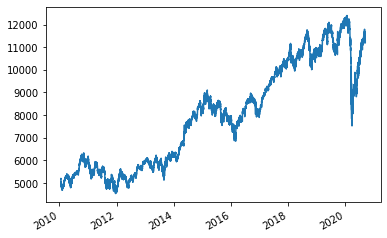

In [9]:
df.Close.plot()

### Sample OHLC data 
* func to resample OHLC data for desired frequency 

In [8]:
def OHLC_resample(df,freq = "D"):
    # high  = max 
    # low  = min
    # close  = last 
    # open = first 
    sample = df.copy()
    d = pd.DataFrame(index = sample.resample(freq).last().dropna().index)
    d["Close"] = sample.resample(freq).last().dropna().Close
    d["Open"] = sample.resample(freq).first().dropna().Open
    d["High"] = sample.resample(freq).max().dropna().High
    d["Low"] = sample.resample(freq).min().dropna().Low
    
    return d

In [46]:
daily.columns

Index(['Close', 'Open', 'High', 'Low', 'previous_close', 'CH-CL', 'CH-PC',
       'CL-PC', 'True_Range', 'ATR'],
      dtype='object')

In [9]:
daily = OHLC_resample(df,freq = "D")
week = OHLC_resample(df,freq = "W")

## Indicators

### MACD 


In [10]:
def macd(close_price,
         fast,
         slow,
         signal):
    
    df = close_price.to_frame()
    df["ema_fast"] = df.iloc[:,0].ewm(span=fast,min_periods=fast).mean()
    df["ema_slow"] = df.iloc[:,0].ewm(span=slow,min_periods=slow).mean()
    df["macd"] = df.ema_fast - df.ema_slow
    df["signal"] = df["macd"].ewm(span=signal,min_periods=signal).mean()
    df.dropna(inplace = True)
    
    return df
    

In [11]:
daily

,Close,Open,High,Low
2010-01-21,5093.7002,5194.8501,5203.4502,5085.4502
2010-01-22,5029.6499,5009.8501,5077.0000,4954.8501
2010-01-25,5001.5498,5014.0498,5035.7002,4983.0498
2010-01-27,4837.1499,4958.0498,4963.7998,4833.0498
2010-01-28,4876.0498,4887.7500,4929.8999,4824.9502
...,...,...,...,...
2020-09-03,11535.7500,11568.4502,11584.9502,11507.6504
2020-09-04,11356.5000,11365.5000,11452.0498,11303.6504
2020-09-07,11375.1504,11364.9004,11381.1504,11251.7002
2020-09-08,11295.8496,11379.0000,11437.2500,11290.4502


calculting and ploting MACD on daily data 

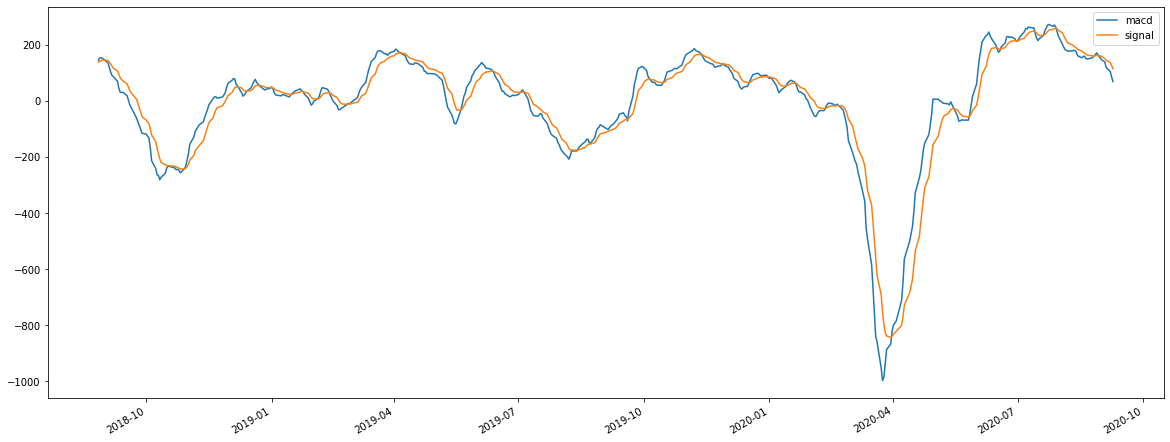

In [12]:
m = macd(daily.Close,
    fast = 12,
    slow = 26,
    signal = 9)

m.iloc[-500:,3:].plot(figsize = (20,8))
plt.show()

### ATR

In [36]:
def atr(df,
        n):
    
    df["previous_close"] = df.Close.shift(1)
    df.dropna(inplace = True)

    df['CH-CL']=abs(df['High'] - df['Low'])
    df['CH-PC']=abs(df['High'] - df["previous_close"])
    df['CL-PC']=abs(df['Low']  - df["previous_close"])

    df['True_Range'] = df.loc[:,['CH-CL', 'CH-PC', 'CL-PC']].max(axis = 1)
    df['ATR'] = df['True_Range'].rolling(n).mean()
    df = df[["ATR"]].dropna().copy()
    
    return df

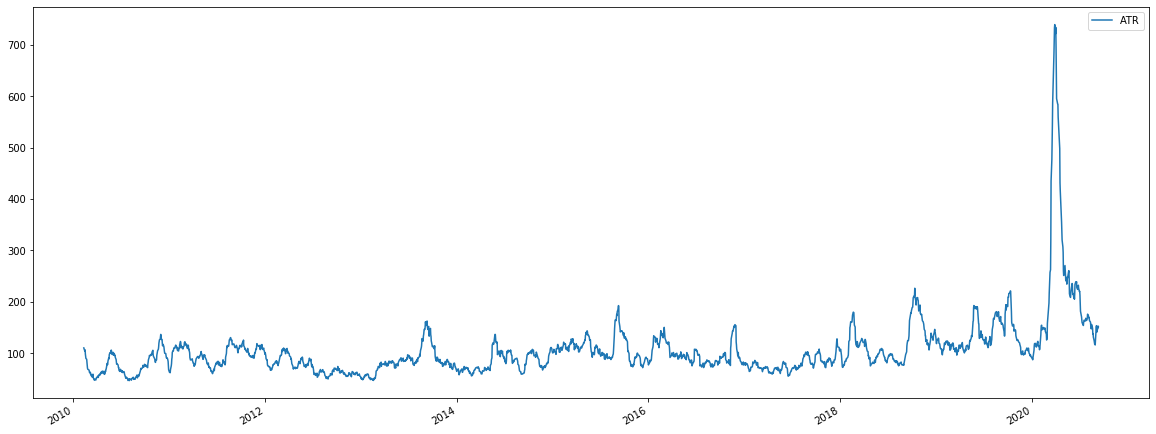

In [38]:
a = atr(daily,14)
a.plot(figsize = (20,8))
plt.show()

### Bollinger band

In [19]:
def bollinger_band(close_price,
                   n,
                   std):
    
    df = close_price.to_frame()
    df["sma"] = df.Close.rolling(n).mean()
    df["rolling_std"] = df.Close.rolling(n).std()
    df["upper_band"] = df.sma + (df.rolling_std * std) 
    df["lower_band"] = df.sma - (df.rolling_std * std) 
    df["width"] = df["upper_band"] - df["lower_band"]
    df.dropna(inplace=True)
    
    return df


In [20]:
s = bollinger_band(daily.Close,
              n = 20,
              std = 2)

In [55]:
s.columns

Index(['Close', 'sma', 'rolling_std', 'upper_band', 'lower_band', 'width'], dtype='object')

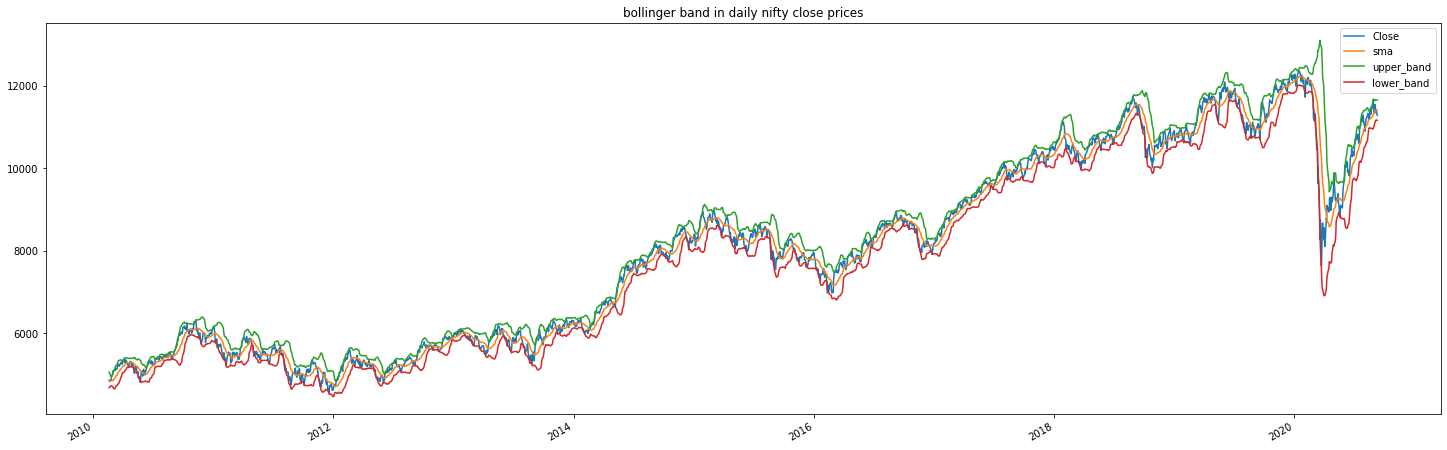

In [34]:
s.loc[:,['Close', 'sma','upper_band','lower_band']].plot(figsize = (25,8))
plt.title("bollinger band in daily nifty close prices")
plt.show()

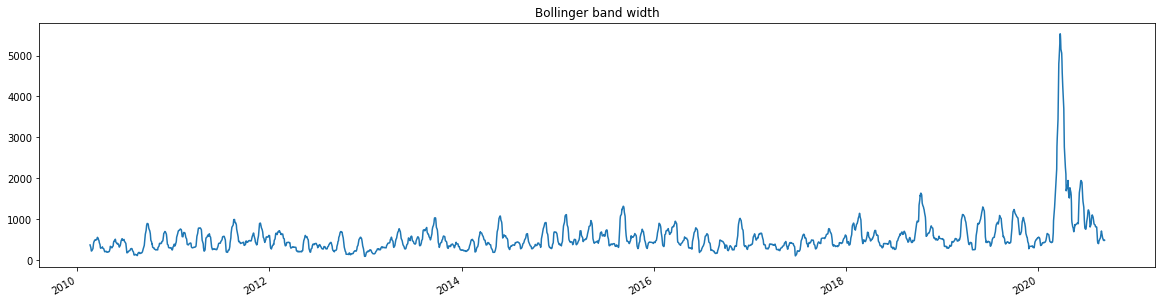

In [35]:
s.width.plot(figsize = (20,5))
plt.title("Bollinger band width")
plt.show()

### RSI

In [26]:
def rsi(close_price,
       n):
    
    df = close_price.to_frame()
    # calulate diffrence in price in rs from prevous day to current day 
    df["diff"] = df.Close.diff()

    # seprate the diffrence value in gain and loss columns and they should be in absolute terms  
    df["gain"] = np.where(df["diff"] > 0,abs(df["diff"]),0)
    df["loss"] = np.where(df["diff"] < 0,abs(df["diff"]),0)
    df.dropna(inplace=True)

    # calculate average gain and average loss
    df["avg_gain"] = df.gain.rolling(n).mean()
    df["avg_loss"] = df.loss.rolling(n).mean()

    # now calculate RS relative strenght RS = Average gain/Average Loss
    df["RS"] = df.avg_gain/df.avg_loss

    # formula for RSI 
    # RSI = 100 - (100/(1+RS))
    df.dropna(inplace=True)
    df["RSI"] = 100 - (100/(1 + df.RS))
    
    return df.RSI

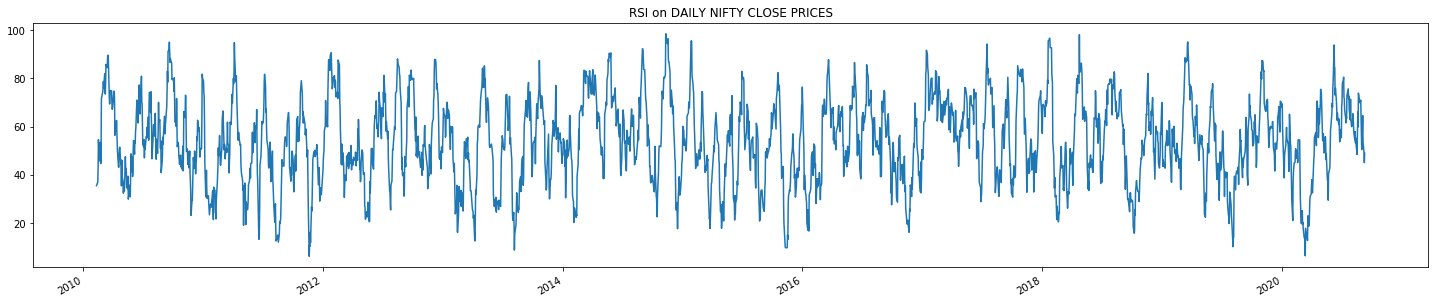

In [32]:
rsi(daily.Close,14).plot(figsize = (25,5))
plt.title("RSI on DAILY NIFTY CLOSE PRICES")
plt.show()